In [1]:
using LazySets, Polyhedra
using Plots; gr()

Plots.GRBackend()

In [2]:
hp = Hyperplane([1., 1.], 1.)

Hyperplane{Float64, Vector{Float64}}([1.0, 1.0], 1.0)

In [3]:
a = [1. 1.]
a, -a

([1.0 1.0], [-1.0 -1.0])

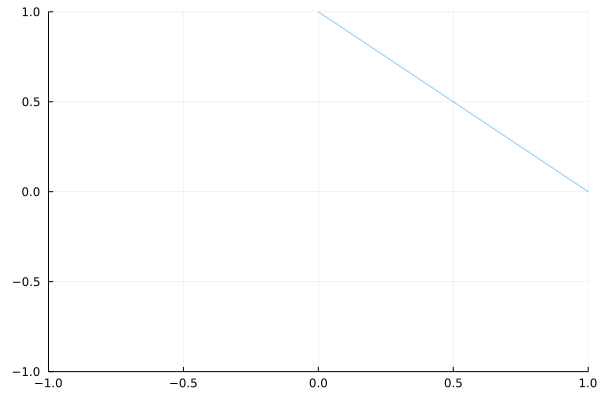

In [4]:
plot(hp)

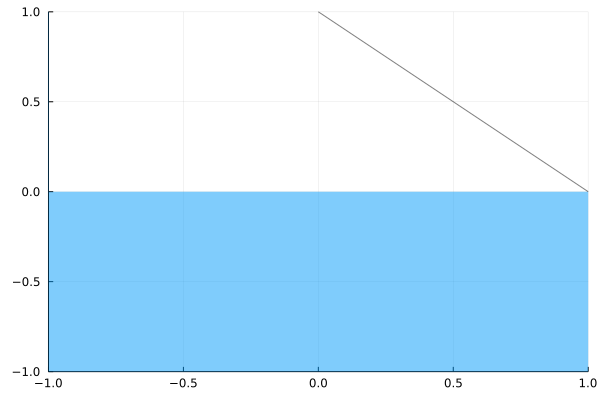

In [5]:
hs = LazySets.HalfSpace([1., 1.], 1.)
plot(hs)


In [6]:
H = randn(5,2)
h = randn(5,1)
H,h

([-0.19921385622616897 0.9925473241986427; -1.4677941602817624 0.3803767888272034; … ; -0.7454599618718488 0.1203807139176085; 0.38581706380723013 1.4872687026889135], [-0.6625343674963956; 0.884767060239103; … ; 0.5647975728637117; 1.1299412693663693;;])

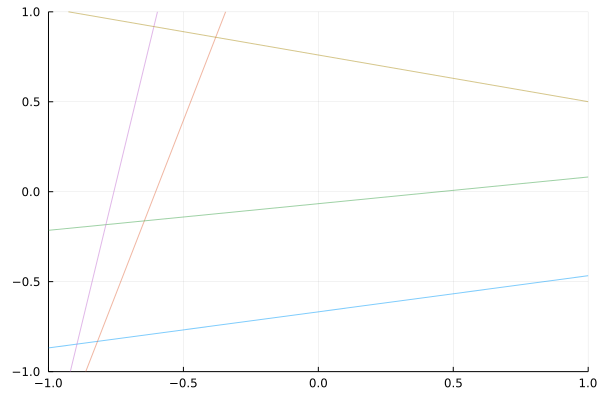

In [7]:
hplanes = [Hyperplane(H[i,:],h[i]) for i in 1:size(H,1)]

plot(hplanes)

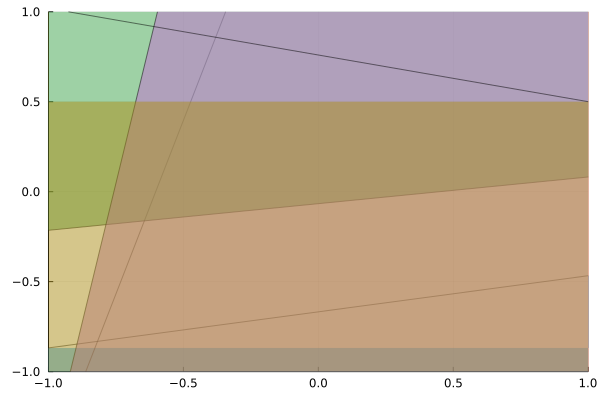

In [8]:
hspaces = [LazySets.HalfSpace(H[i,:],h[i]) for i in 1:size(H,1)]
plot(hspaces)

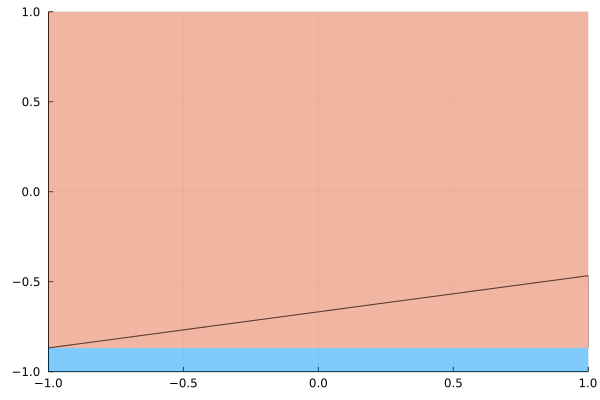

In [9]:
plot(hspaces[1])
plot!(complement(hspaces[1]))

In [10]:
function count_binary!(X)
    for i in 1:length(X)
        X[i] = -X[i]
        if X[i] > 0
            return X
        end
    end
end

function create_hrep(H,h)
    return reduce(∩, (LazySets.HalfSpace(-H[i,:], h[i]) for i in 1:size(H,1) if !all(H[i,:] .== 0)))
end

X = -ones(3)
for i in 1:10
    println(X)
    count_binary!(X)
end



[-1.0, -1.0, -1.0]
[1.0, -1.0, -1.0]
[-1.0, 1.0, -1.0]
[1.0, 1.0, -1.0]
[-1.0, -1.0, 1.0]
[1.0, -1.0, 1.0]
[-1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[-1.0, -1.0, -1.0]
[1.0, -1.0, -1.0]


16


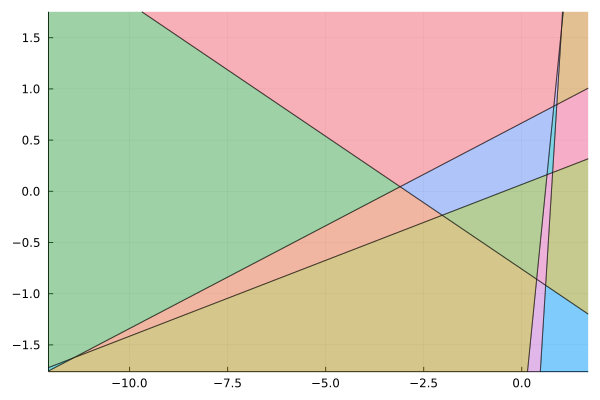

In [11]:
function partition_naive(W,b)
    return partition_naive(W,b,Universe(size(W,2)))
end

function partition_naive(W,b,initial_region)
    regions = []
    signs = -ones(size(W,1))
    iH,ih = tosimplehrep(initial_region)
    for i in 1:2^size(W,1)
        s = signs
        if !all(s .== 0)
            # Have to invert iH, because create_hrep inverts it agains
            hrep = create_hrep(vcat(-iH, s .* W), vcat(ih, s .* b))
            if !isempty(hrep)
                push!(regions, [copy(signs), hrep])
            end
        end
        count_binary!(signs)
    end
    return regions
end

regions_naive = partition_naive(H,h)
println(length(regions_naive))

plot()
for (s, r) in regions_naive
    plot!(r)
end
plot!()

In [12]:
struct RegionNode
    parent::LazySets.HPolyhedron
    children::Vector{RegionNode}
    signs::Vector{Vector{Int}}
end


function partition!(node::RegionNode, layer::Int, hspaces::Vector{LazySets.HalfSpace{Float64,Vector{Float64}}})
    for (i, hspace) in enumerate(hspaces)
        partition!(node, hspace, layer, i)
    end
end

function partition!(node::RegionNode, hspace::LazySets.HalfSpace, layer::Int, idx::Int)
    # Check if the region intersects with the halfspace
    intersection = node.parent ∩ hspace
    is_empty = isempty(intersection)
    if !is_empty
        # Check if the region also intersects with the complement of the halfspace 
        intersection_c = node.parent ∩ complement(hspace)
        is_empty_c = isempty(intersection_c)

        if !is_empty_c
            # Both halfspaces intersect, so the function switches in this region.
            if isempty(node.children)
                # If there are no subregions, we need to branch
                push!(node.children, RegionNode(intersection, [], [[layer, idx, 1]]))
                push!(node.children, RegionNode(intersection_c, [], [[layer, idx, 0]]))
            else
                # Check intersections with all subregions
                for child in node.children
                    partition!(child, hspace, layer, idx)
                end
            end
            return
        end
    end

    # Cache which side of the switching boundary this region is on
    push!(node.signs, [layer, idx, is_empty ? 0 : 1])
end


function get_regions(node::RegionNode)
    return get_regions(node, [])
end

function get_regions(node::RegionNode, regions::Vector)
    if length(node.children) > 0
        for c in node.children
            get_regions(c, regions)
        end
    else
        push!(regions, node)
    end
    return regions
end

import Base: length
function length(node::RegionNode)::Int
    if isempty(node.children)
        return 1
    else
        return sum(length(c) for c in node.children)
    end
end

function plot_regions(node::RegionNode)
    if isempty(node.children)
        plot!(node.parent)
    else
        for c in node.children
            plot_regions(c)
        end
    end
end

function plot_regions(nodes::Vector{Any})
    for node in nodes
        plot_regions(node)
    end
end



plot_regions (generic function with 2 methods)

## Recursive algorithm

Instead of enumerating all of the possibilities, let's try building it up recursively.

In [13]:
# Define the 2-layer network

W1 = randn(5,2)
b1 = randn(5)

W2 = randn(2,5)
b2 = randn(2)


2-element Vector{Float64}:
 0.47919135683076775
 0.25833732528900305

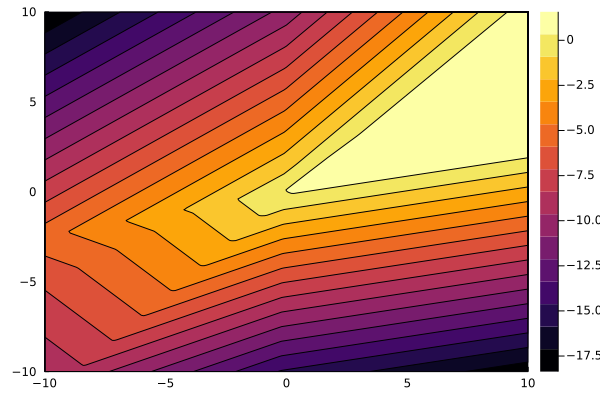

In [14]:
x = collect(-10:0.1:10)
y = x
f(x, y) = W2[1,:]'*max.(0, W1[:,1]*x + W1[:,2]*y + b1) .+ b2[1]
plot(x,y,f, st=:contourf)


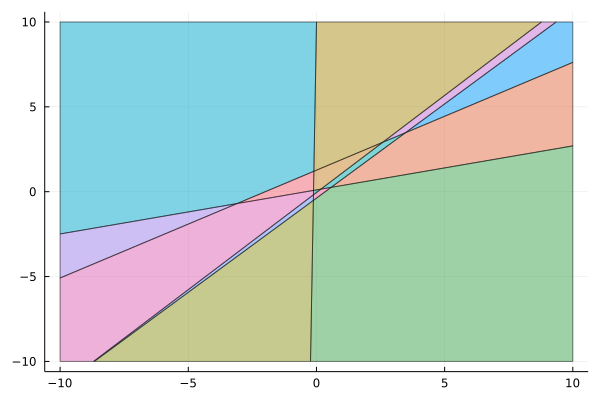

In [15]:
box = Hyperrectangle([0.,0.],[10.,10.])
regions1_naive = partition_naive(W1, b1,box)
plot()
for (s,r) in regions1_naive
    plot!(r)
end
plot!()

In [16]:
length(regions1_naive)

15

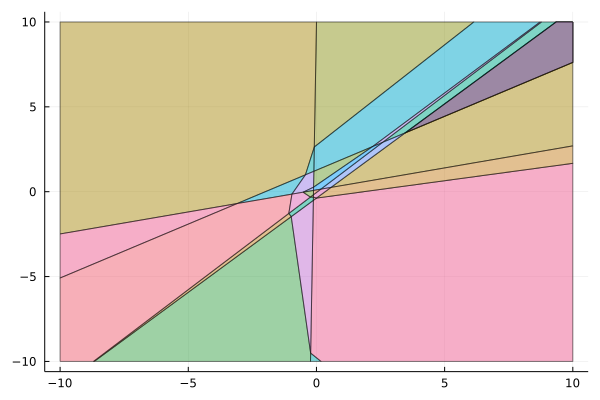

In [17]:
regions2_naive = []
for (s,r) in regions1_naive
    # Apply activations
    signs = max.(0,s)
    W = W2 * (signs .* W1)
    b = W2 * (signs .* b1) + b2
    regions2_naive = vcat(regions2_naive, partition_naive(W,b,r))
end

plot()
for (s,r) in regions2_naive
    plot!(r)
end
plot!()


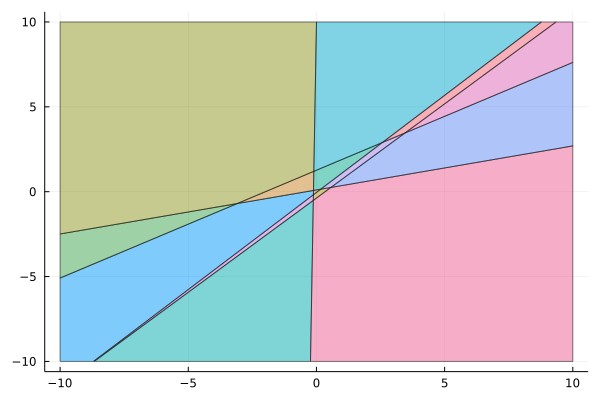

In [18]:

regions1 = RegionNode(Hyperrectangle([0.,0.],[10.,10.]), [], [])
# regions1 = RegionNode(Universe(2), [], [])
C1 = [LazySets.HalfSpace(-W1[i,:], b1[i]) for i in 1:size(W1,1)]

partition!(regions1,1,C1)

plot()
plot_regions(regions1)
plot!()

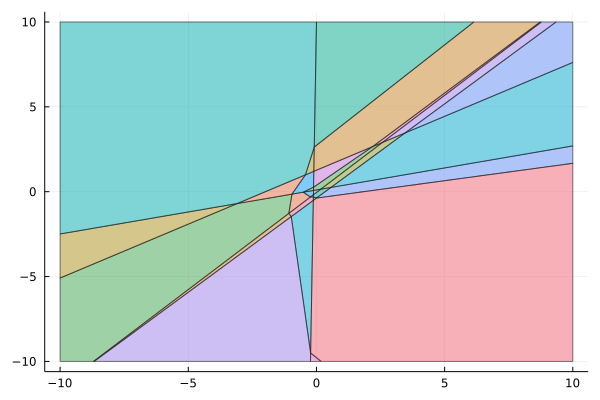

In [19]:
# TODO replace W,b with a neural network struct
nodes = [regions1]
signs1 = zeros(size(W1,1))
while !isempty(nodes)
    n = pop!(nodes)

    for (l, i, s) in n.signs
        signs1[i] = s 
    end

    # When we reach a leaf node, we expect that the complete activation pattern
    # has been reconstructed in the signs vector
    if isempty(n.children)
        if !all(s == 0 for s in signs1) # A zero region will have no splits

            # Construct the local affine function Wx + b computed by the network
            W = W2 * (signs1 .* W1)
            b = W2 * (signs1 .* b1) + b2

            # Construct the halfspace {Wx + b > 0} and add it to the PWA tree
            C = [LazySets.HalfSpace(-W[i,:], b[i]) for i in 1:size(W,1)]
            partition!(n,2,C)
        end
    else
        push!(nodes, n.children[1])
        push!(nodes, n.children[2])
    end
end


nothing
plot()
plot_regions(regions1)
# for r in regs
#     scatter!([pointmap[r][1]], [pointmap[r][2]])
# end
plot!()

# Practical implementations
Now that we can show that it works, and we've verified it against a (probably) correct implmentation, we can try to implement a function for an arbitrary network. 
- [ ] Split up code into tree iteration func and action func (maybe the actual code can remain as it is to keep it optimised?)

It would be nice to compute the following operations:
- [ ] Convolutions
- [ ] Other common activation functions like Leaky ReLu, maxout, etc
- [ ] Arbitrary PWA functions (as a fallback)
- [ ] Skip connections (theoretically, I don't think that this adds additional regions)
  - [ ] Need a way to easily check if a region is a subregion of another (I think just checking if the first n activations are equal)

In [20]:
include("src/NeuralVerification.jl")
nv = NeuralVerification
"""
Layer{F, N}
- Consists of `weights` and `bias` for linear mapping, and `activation` for nonlinear mapping.
- Fields
    - `weights::Matrix{N}`
    - `bias::Vector{N}`
    - `activation::F`

A Vector of layers.
- Network([layer1, layer2, layer3, ...])
"""

"Layer{F, N}\n- Consists of `weights` and `bias` for linear mapping, and `activation` for nonlinear mapping.\n- Fields\n    - `weights::Matrix{N}`\n    - `bias::Vector{N}`\n    - `activation::F`\n\nA Vector of layers.\n- Network([layer1, layer2, layer3, ...])\n"

In [30]:
function rand_nnet(arch)#, activation::GeneralAct)
    n_prev = arch[1]
    layers = []
    for n in arch[2:end]
        push!(layers, nv.Layer(randn(n,n_prev), randn(n), nv.ReLU()))
        n_prev = n
    end
    return nv.Network(layers)
end


rand_nnet (generic function with 1 method)

In [66]:
function pwa!(nnet::nv.Network, domain)
    root = RegionNode(domain, [], [])
    N = LazySets.dim(domain)

    # Number of neurons in layer i
    n_neurons = [length(layer.bias) for (i,layer) in enumerate(nnet.layers) ]

    # Current activation pattern
    signs = [zeros(n_neurons[i]) for (i,layer) in enumerate(nnet.layers)]

    # Allocate W and b
    WW = [zeros(n_neurons[i], N) for (i,layer) in enumerate(nnet.layers)]
    bb = [zeros(n_neurons[i]) for (i,layer) in enumerate(nnet.layers)]
    
    # TODO Refactor into main layer loop
    WW[1],bb[1] = nnet.layers[1].weights, nnet.layers[1].bias
    for i_node in 1:size(WW[1], 1)
        # A zero region will have no splits
        if !all(WW[1][i_node,:] .== 0)
            # Insert halfspace into PWA tree
            partition!(root, LazySets.HalfSpace(-WW[1][i_node, :], bb[1][i_node]), 1, i_node)
        end
    end
    
    # node_layer = 1
    # node_neuron = 1

    for i_layer in 2:length(nnet.layers)
        nodes = [root]

        while !isempty(nodes)
            n = pop!(nodes)

            # Update activation pattern
            for (l, i, s) in n.signs
                signs[l][i] = s
                # node_neuron += 1
            end

            # while node_neuron > n_nodes[node_layer]
            #     node_neuron -= n_nodes[node_layer]
            #     node_layer += 1
            # end
            
            if isempty(n.children)
                # Construct the local affine function Wx + b computed by the network
                # TODO Refactor local affine func into function
                """
                    W1
                    b1
                    W2 * (signs1 .* W1)
                    W2 * (signs1 .* b1) + b2
                    W3 * (signs2 .* W2) * (signs1 .* W1)
                    W3 * signs2 .* (W2 * (signs1 .* b1) + b2) + b3
                """
                # Compute local linear transformation using activation pattern
                # TODO Share computations between nodes on same branch
                for i in 2:(i_layer)
                    WW[i] = nnet.layers[i].weights * (signs[i-1] .* WW[i-1])
                    bb[i] = nnet.layers[i].weights * (signs[i-1] .* bb[i-1]) + nnet.layers[i].bias
                end               

                # Construct the halfspaces {Wi x + bi > 0}
                # TODO call halfspace intersection functions manually
                for i_node in 1:size(WW[i_layer], 1)
                    # A zero region will have no splits
                    if !all(WW[i_layer][i_node,:] .== 0)
                        # Insert halfspace into PWA tree
                        partition!(n, LazySets.HalfSpace(-WW[i_layer][i_node, :], bb[i_layer][i_node]), i_layer, i_node)
                    end
                end

                
            else
                push!(nodes, n.children[1])
                push!(nodes, n.children[2])
            end
        end
    end

    return root
end

D = 3
net = rand_nnet([D,10,10,1])#, ReLU)
regions = pwa!(net, Hyperrectangle(zeros(D), 20. * ones(D)))

println(length(regions))

if D == 2
    plot()
    plot_regions(regions)
    plot!()
end

2463


In [57]:
# TODO Implement traversal function
# TODO make struct that includes tree + nnet

function traverse(node::RegionNode, nnet::nv.Network, func::Function)
    N = LazySets.dim(node.parent)

    # Number of neurons in layer i
    n_neurons = [length(layer.bias) for (i,layer) in enumerate(nnet.layers) ]

    # Current activation pattern
    signs = [zeros(n_neurons[i]) for (i,layer) in enumerate(nnet.layers)]

    # Allocate W and b
    WW = [zeros(n_neurons[i], N) for (i,layer) in enumerate(nnet.layers)]
    bb = [zeros(n_neurons[i]) for (i,layer) in enumerate(nnet.layers)]
    
    # node_layer = 1
    # node_neuron = 1
    while !isempty(nodes)
        n = pop!(nodes)

        # Update activation pattern
        for (l, i, s) in n.signs
            signs[l][i] = s
            # node_neuron += 1
        end
        
        # while node_neuron > n_nodes[node_layer]
        #     node_neuron -= n_nodes[node_layer]
        #     node_layer += 1
        # end
        
        if isempty(n.children)
            # Construct the local affine function Wx + b computed by the network
            # TODO Refactor local affine func into function
            """
                W1
                b1
                W2 * (signs1 .* W1)
                W2 * (signs1 .* b1) + b2
                W3 * (signs2 .* W2) * (signs1 .* W1)
                W3 * signs2 .* (W2 * (signs1 .* b1) + b2) + b3
            """
            # Compute local linear transformation using activation pattern
            # TODO Share computations between nodes on same branch
            for i in 2:(i_layer)
                WW[i] = nnet.layers[i].weights * (signs[i-1] .* WW[i-1])
                bb[i] = nnet.layers[i].weights * (signs[i-1] .* bb[i-1]) + nnet.layers[i].bias
            end               

            # # Construct the halfspaces {Wi x + bi > 0}
            # # TODO call halfspace intersection functions manually
            # for i_node in 1:size(WW[i_layer], 1)
            #     # A zero region will have no splits
            #     if !all(WW[i_layer][i_node,:] .== 0)
            #         # Insert halfspace into PWA tree
            #         partition!(n, LazySets.HalfSpace(-WW[i_layer][i_node, :], bb[i_layer][i_node]), i_layer, i_node)
            #     end
            # end

            
        else
            push!(nodes, n.children[1])
            push!(nodes, n.children[2])
        end
    end
end

traverse (generic function with 2 methods)

# Benchmarking

In [58]:
using BenchmarkTools


In [67]:
println(length(regions))
@benchmark traverse(regions, net)

2463


BenchmarkTools.Trial: 10000 samples with 89 evaluations.
 Range (min … max):  741.573 ns … 252.581 μs  ┊ GC (min … max):  0.00% … 98.73%
 Time  (median):       1.262 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.689 μs ±   7.599 μs  ┊ GC (mean ± σ):  17.09% ±  3.83%

  ▆█▅       ▁▁                                                   
  ███▇▆▆▅█▆███▇▇▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  742 ns           Histogram: frequency by time         3.98 μs <

 Memory estimate: 1.75 KiB, allocs estimate: 16.

In [54]:
@benchmark length(regions)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  36.900 μs …  16.630 ms  ┊ GC (min … max): 0.00% … 98.91%
 Time  (median):     58.500 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   73.823 μs ± 228.578 μs  ┊ GC (mean ± σ):  4.26% ±  1.39%

  ▆█▃▃▂ ▂                                                       
  █████▇██▆▇▇▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  36.9 μs         Histogram: frequency by time          223 μs <

 Memory estimate: 23.59 KiB, allocs estimate: 1208.

In [51]:
@benchmark pwa!(net, Hyperrectangle([0.,0.], [20.,20.]))

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.588 s …   2.604 s  ┊ GC (min … max): 8.88% … 8.06%
 Time  (median):     2.596 s              ┊ GC (median):    8.47%
 Time  (mean ± σ):   2.596 s ± 11.711 ms  ┊ GC (mean ± σ):  8.47% ± 0.58%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.59 s         Histogram: frequency by time         2.6 s <

 Memory estimate: 836.68 MiB, allocs estimate: 15228806.

In [ ]:

testnet = rand_nnet([2,3,3])#, ReLU)


In [36]:
@benchmark pwa!(testnet, Hyperrectangle([0.,0.], [20.,20.]))

BenchmarkTools.Trial: 104 samples with 1 evaluation.
 Range (min … max):  34.093 ms … 88.106 ms  ┊ GC (min … max): 0.00% … 31.52%
 Time  (median):     43.341 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   48.184 ms ± 13.193 ms  ┊ GC (mean ± σ):  8.06% ± 12.43%

      █                                                        
  ▄▆▆██▇▇▅▃▄▁▄▁▆▆▃▄▁▄▅▄▅▃▅▁▄▁▁▃▁▃▃▃▄▃▆▅▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▃▁▄▁▁▄ ▃
  34.1 ms         Histogram: frequency by time        85.4 ms <

 Memory estimate: 15.37 MiB, allocs estimate: 284732.

In [44]:
function test1()
A = zeros(3,3)
B = ones(3,3)
for i in 1:100
    A .+= i*B
end
return A
end

function test2()
A = zeros(3,3)
B = zeros(3,3)
for i in 1:100
    A = A + i*B 
end
return A
end


test2 (generic function with 1 method)

In [45]:

@benchmark test1

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.001 ns … 18.400 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.001 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.050 ns ±  0.270 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                        ▅  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▂
  0.001 ns       Histogram: frequency by time         0.1 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [46]:
@benchmark test2

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.001 ns … 17.500 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.001 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.038 ns ±  0.301 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                           
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▂
  0.001 ns       Histogram: frequency by time         0.1 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [26]:
an_element(regions.parent)

2-element Vector{Float64}:
 0.0
 0.0